In [ ]:
!git clone https://github.com/susannapaoli/multimodal-memes.git

Cloning into 'multimodal-memes'...
remote: Enumerating objects: 533, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 533 (delta 159), reused 238 (delta 137), pack-reused 265
Receiving objects: 100% (533/533), 4.68 MiB | 7.20 MiB/s, done.
Resolving deltas: 100% (272/272), done.


**Get data from Kaggle**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
files.upload()

Mounted at /content/drive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annalisabarbara","key":"f3e17385dc26a70415d8fbf3d93ef180"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d parthplc/facebook-hateful-meme-dataset

100% 3.35G/3.35G [03:12<00:00, 20.0MB/s]
100% 3.35G/3.35G [03:12<00:00, 18.7MB/s]


In [ ]:
!unzip /content/facebook-hateful-meme-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/img/49758.png      
  inflating: data/img/49762.png      
  inflating: data/img/49785.png      
  inflating: data/img/49786.png      
  inflating: data/img/49802.png      
  inflating: data/img/49805.png      
  inflating: data/img/49806.png      
  inflating: data/img/49807.png      
  inflating: data/img/49810.png      
  inflating: data/img/49826.png      
  inflating: data/img/49831.png      
  inflating: data/img/49832.png      
  inflating: data/img/49836.png      
  inflating: data/img/49850.png      
  inflating: data/img/49856.png      
  inflating: data/img/49861.png      
  inflating: data/img/49863.png      
  inflating: data/img/49867.png      
  inflating: data/img/49870.png      
  inflating: data/img/50124.png      
  inflating: data/img/50126.png      
  inflating: data/img/50129.png      
  inflating: data/img/50137.png      
  inflating: data/img/50142.png      
  inflating: data/img/50146.png      

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 450.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.4 MB/s eta 0:00:00


In [ ]:
'''
IMPORTING NECESSARY MODULES
'''

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

sys.path.append('/content/drive/MyDrive/hateful-speech-memes 2/GPT')
sys.path.append('/content/drive/MyDrive/hateful-speech-memes 2/multimodal-memes')
sys.path.append('/content/drive/MyDrive/hateful-speech-memes 2/Utils')
sys.path.append('/content/drive/MyDrive/hateful-speech-memes 2/Data')
sys.path.append('/content/drive/MyDrive/hateful-speech-memes 2/Resnet')
sys.path.append('/content/drive/MyDrive/hateful-speech-memes 2/Data/data/img')

from dataloader import myfusiondataset
#from Load_model import load
from plot_curves import plot_loss, plot_acc
from multimodal_trainer import train, test_classify

'''
For ResNet/ ResNeXt
'''
from resnet_model import ResNet,Bottleneck, resnext101_32x8d


'''
For GPT2
'''
from transformers import GPT2ForSequenceClassification, AdamW, GPT2Config
from transformers import get_linear_schedule_with_warmup

**Device**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


**Dataloading Scheme**

In [ ]:
%cd /content/drive/MyDrive/hateful-speech-memes 2/JSON Data

/content/drive/.shortcut-targets-by-id/1qPisF4YTvekCsTOA69h1u8Vbi-hqWJcT/hateful-speech-memes 2/JSON Data


In [ ]:
%cd /content/data

/content/data


In [ ]:
trainlist = 'train.jsonl'
validlist = 'dev.jsonl'

In [ ]:
'''
Train Dataloader
''' 
train_dataset = myfusiondataset(trainlist, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 16, num_workers=8, pin_memory=True)


'''
Validation Dataloader
''' 
validation_dataset = myfusiondataset(validlist, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 32, num_workers=8, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


**Model Definition**

In [ ]:
'''
Model1 ResNeXt101_32x8d
'''
Image_model = resnext101_32x8d()

Image_model.fc = nn.Sequential(
    nn.Linear(Image_model.fc.in_features, 2)
    )

Image_model = nn.DataParallel(Image_model).to(device)

Image_model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [ ]:
'''
Model 2 GPT2

Load GPT2ForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
''' 

Text_model = GPT2ForSequenceClassification.from_pretrained(
    "gpt2", 
    num_labels = 2,   
    output_attentions = False, 
    output_hidden_states = True
)
Text_model.config.pad_token_id = Text_model.config.eos_token_id
Text_model = nn.DataParallel(Text_model).to(device)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
'''
Fusion
'''
class FusionNet(nn.Module):
    
    def __init__(self, num_classes, drop_prob = 0.1):
        super(FusionNet, self).__init__()
        
        self.pooler = nn.Linear(in_features=768, out_features=768)
        
        self.concat = nn.Linear(in_features=768+2048, out_features= 512)
        
        self.bn = nn.BatchNorm1d(512)
        self.bn1 = nn.BatchNorm1d(768)
        self.bn2 = nn.BatchNorm1d(2048)
    
        self.dropout = nn.Dropout(drop_prob)
        
        self.classify = nn.Linear(in_features = 512, out_features = num_classes)
        
        
    def forward(self, text_features, image_features):
        text_features = torch.tanh(self.pooler(text_features))
        text_features = self.dropout(text_features)

        text_features = self.bn1(text_features)
        image_features = self.bn2(image_features)
      
        fused =  torch.cat((text_features, image_features), dim=1)
        
        x = self.concat(fused)
        x = F.tanh(self.bn(x))
        
        x = F.tanh(self.classify(x))

        return x



In [ ]:
Fusion_model = FusionNet(num_classes =2 , drop_prob = 0.1)
Fusion_model = nn.DataParallel(Fusion_model).to(device)

**Hyperparameters**

In [ ]:
'''
Loss Function
'''
criterion = nn.CrossEntropyLoss()

In [ ]:
model_name = 'Concatenation'
model_path = './saved_model_checkpoints/' + model_name

In [ ]:
import itertools

def grid_search(model, criterion, hyperparameters):
    best_accuracy = 0
    best_hyperparameters = {}
    hyperparameter_combinations = list(itertools.product(*hyperparameters.values()))

    for combination in hyperparameter_combinations:
        hyperparameter_dict = dict(zip(hyperparameters.keys(), combination))
        print("Testing with hyperparameters: ", hyperparameter_dict)

        optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameter_dict['learning_rate'], 
                                    weight_decay=hyperparameter_dict['weight_decay'], 
                                    momentum=hyperparameter_dict['momentum'])

        num_Epochs = hyperparameter_dict['num_Epochs']
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=hyperparameter_dict['gamma'])

        writer = SummaryWriter(model_name)


        train_loss, v_loss, v_acc = train(Image_model, Text_model, Fusion_model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, model_path, writer, device, epochs = num_Epochs)

        plot_loss(num_Epochs, train_loss, v_loss, 'GPT2 + Resnet')

        plot_acc(num_Epochs, v_acc)
        
        
        print(f"{v_acc=} {v_loss=} {hyperparameter_dict['learning_rate'] = } {hyperparameter_dict['weight_decay']=} {hyperparameter_dict['momentum'] = } {hyperparameter_dict['num_Epochs']=}")
        if v_acc > best_accuracy:
          best_accuracy, best_hyperparameters = v_acc, hyperparameter_dict

        writer.flush()
        writer.close()

        plot_loss(num_Epochs, train_loss, v_loss, 'XLNet + Resnet')

        plot_acc(num_Epochs, v_acc)

    print("\nBest Hyperparameters Found:")
    print(best_hyperparameters)
    print(f"\nBest Validation Accuracy: {best_accuracy:.4f}")
    return best_hyperparameters

Testing with hyperparameters:  {'learning_rate': 0.0001, 'weight_decay': 1e-05, 'momentum': 0.9, 'num_Epochs': 8, 'gamma': 0.1}
Epoch:  1
training loss =  0.6459723253335271
Validation Loss: 0.7298	Validation Accuracy: 0.5020
Epoch:  2
training loss =  0.6484592031491431
Validation Loss: 0.7304	Validation Accuracy: 0.5020
Epoch:  3
training loss =  0.6477300475974729
Validation Loss: 0.7280	Validation Accuracy: 0.5040
Epoch:  4
training loss =  0.6469863895186805
Validation Loss: 0.7315	Validation Accuracy: 0.5020
Epoch:  5
training loss =  0.6458206320727679
Validation Loss: 0.7245	Validation Accuracy: 0.5080
Epoch:  6
training loss =  0.6477673239725873
Validation Loss: 0.7314	Validation Accuracy: 0.5060
Epoch:  7
training loss =  0.646791293993032
Validation Loss: 0.7308	Validation Accuracy: 0.5080
Epoch:  8
training loss =  0.6476756125352436
Validation Loss: 0.7274	Validation Accuracy: 0.5020
v_acc=[0.502, 0.502, 0.504, 0.502, 0.508, 0.506, 0.508, 0.502] v_loss=[0.7298037555217743

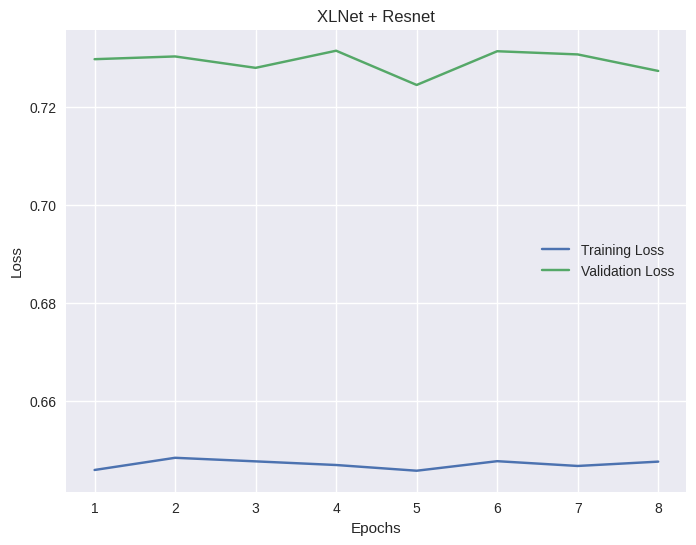

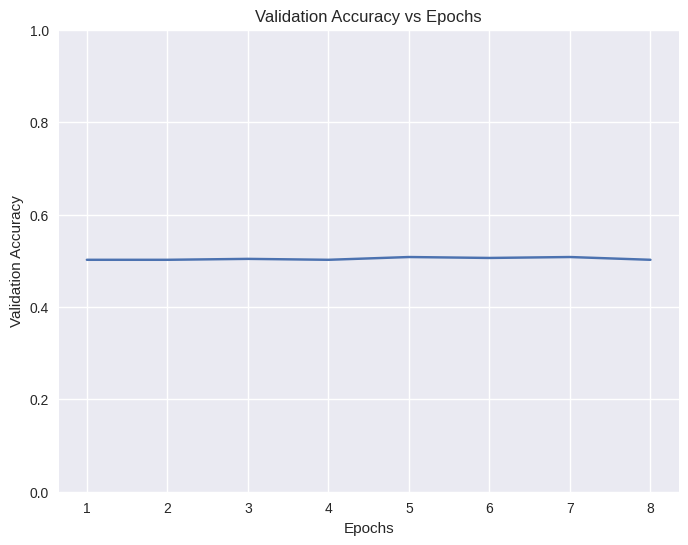

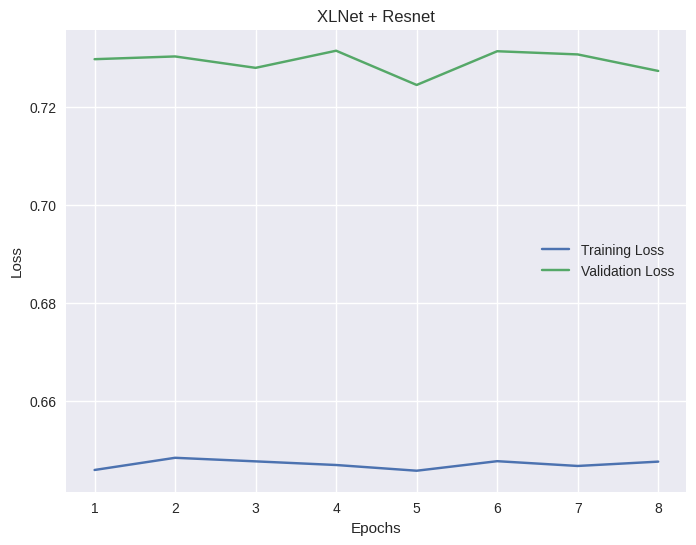

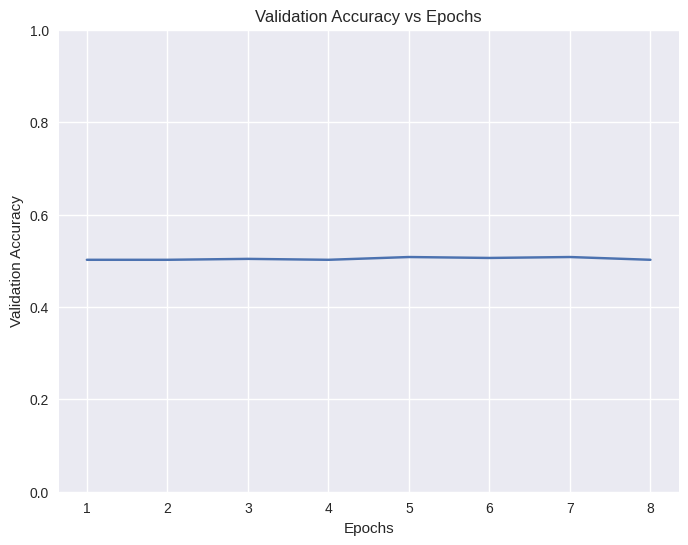

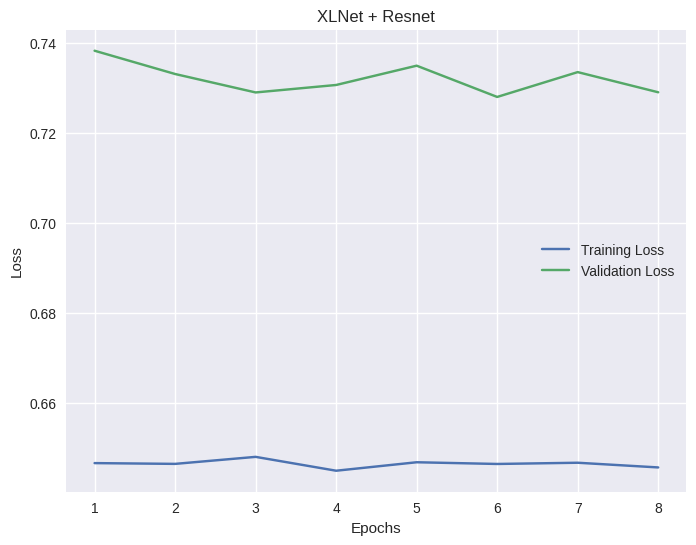

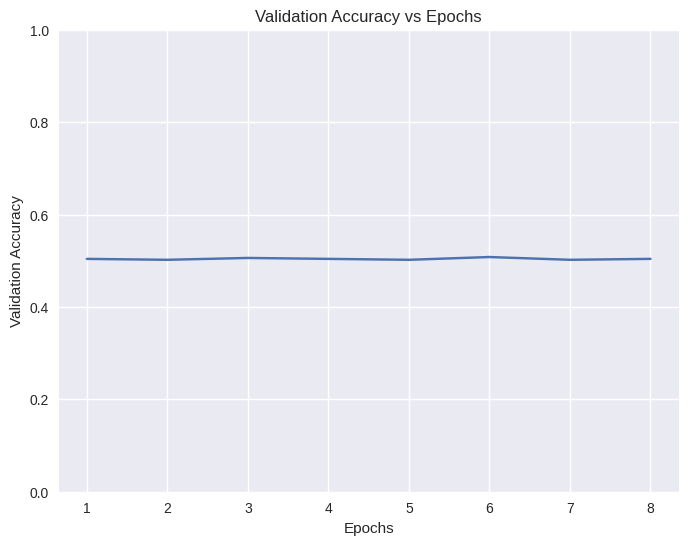

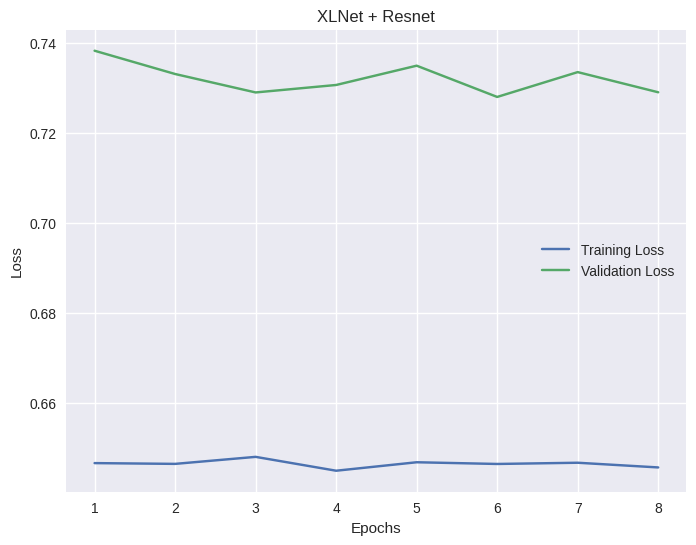

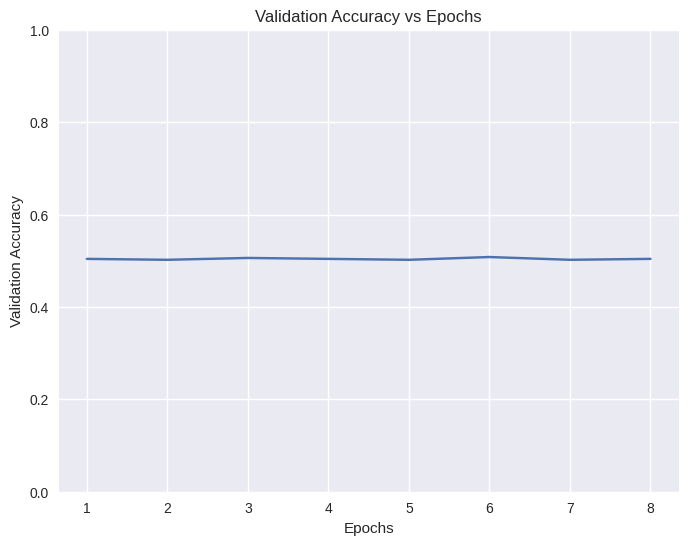

In [ ]:
hyperparameters = {'learning_rate': [1e-4],
                   'weight_decay': [1e-5, 1e-4],
                   'momentum': [0.9],
                   'num_Epochs': [8],
                   'gamma': [0.1]}
best_hyperparameters = grid_search(Fusion_model, criterion, hyperparameters)

In [ ]:

'''
Optimizer
'''
# optimizer = torch.optim.SGD(Fusion_model.parameters(), lr=1e-4, weight_decay=1e-2, momentum=0.9)
optimizer = torch.optim.Adam(Fusion_model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-3)

'''
Number of training epochs.
'''
num_Epochs = 10
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 4, gamma = 0.1)

In [ ]:
writer = SummaryWriter(model_name)

train_loss, v_loss, v_acc = train(Image_model, Text_model, Fusion_model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, model_path, writer, device, epochs = num_Epochs)

writer.flush()
writer.close()

Epoch:  1
training loss =  0.674535375116463
Validation Loss: 0.7283	Validation Accuracy: 0.4580
Epoch:  2
training loss =  0.6630246392766336
Validation Loss: 0.7219	Validation Accuracy: 0.4620
Epoch:  3
training loss =  0.6571795268166334
Validation Loss: 0.7428	Validation Accuracy: 0.4600
Epoch:  4
training loss =  0.6537633291760782
Validation Loss: 0.7284	Validation Accuracy: 0.4660
Epoch:  5
training loss =  0.6496397503896764
Validation Loss: 0.7189	Validation Accuracy: 0.4920
Epoch:  6
training loss =  0.6435003200531902
Validation Loss: 0.7146	Validation Accuracy: 0.4940
Epoch:  7
training loss =  0.6474897102417803
Validation Loss: 0.7171	Validation Accuracy: 0.5020
Epoch:  8
training loss =  0.6457450916444448
Validation Loss: 0.7279	Validation Accuracy: 0.5000
Epoch:  9
training loss =  0.6452332686324765
Validation Loss: 0.7190	Validation Accuracy: 0.5020
Epoch:  10
training loss =  0.6439947636055767
Validation Loss: 0.7160	Validation Accuracy: 0.5040


**Plots**

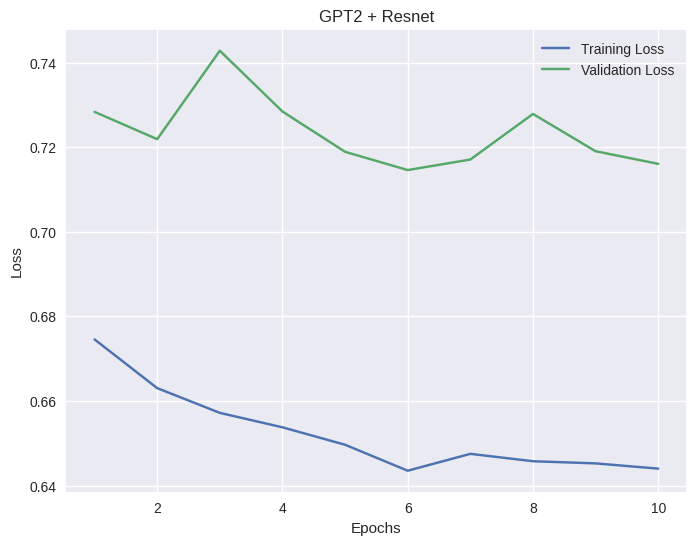

In [ ]:
plot_loss(num_Epochs, train_loss, v_loss, 'GPT2 + Resnet')

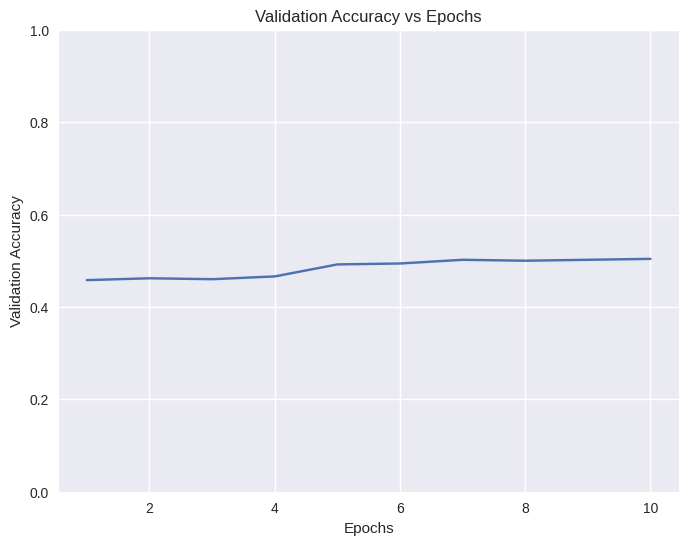

In [ ]:
plot_acc(num_Epochs, v_acc)